# Music recommender

So far, we discussed the main principles and steps involved in building vanilla GNN. In this notebook, we are going to analyse, such basic architecture can be expanded to build a music recommender system.

### Dataset
In this practical, we are going to use LightGCN for [Spotify Million Playlist Dataset Challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge). This dataset contains 1 million playlists created by users on the Spotify between 2010 and 2017. Due to large size, we will only use part of the dataset.

In short, our goal is to recommend songs that should be added to each playlist.

### Model

As we have learned in the previous notebook, GNNs learn by updating node embeddings based on the near node and, later on, global graph information.

GNN multilayer structure functions in three main steps:
1. Each neighbour passes its embedding to the node (**message**)
2. Messages are then **aggregated** to obtain a single embedding
3. Taking previous embedding and combining with the current aggregated embedding to update the node

#### LightGCN

For this particular problem, we are going to use LightGCN architecture and collaborative filtering approach. They key idea of LightGCN is that the only learned parameters are in the initial layer of each node. In other words, we are only updating the start layer using the further layer information which increases speed.

To make final predictions, we are going to take an average of the embeddings at each layer.

## Implementation

In contrast to the previous examples, our music recommender system model will be implemented in Pytorch rather than Keras (only recently introduced GNNs).

#### Setting Up

In [4]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
    
#Downloading data from the original source
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/data_object.pt
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/dataset_stats.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/song_info.json
! wget https://raw.githubusercontent.com/ba305/LightGCN-Spotify/main/data/dataset_large/playlist_info.json

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ---------------------------------------- 7.8/7.8 MB 4.1 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\marty\anaconda3\envs\ai_learning\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\marty\anaconda3\envs\ai_learning\python.exe -m pip install --upgrade pip' command.


Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     ---------------------------------------- 3.8/3.8 MB 3.2 MB/s eta 0:00:00


In [32]:
#Importing required libraries
import json
import numpy as np
import os
import torch
from torch_geometric import seed_everything
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import degree
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from sklearn.decomposition import PCA
from IPython.display import HTML
import matplotlib

seed_everything(5)

#### Loading data

As we have mentioned previously, we are going to use only a part of the whole 33GB dataset. For the simplicity reasons, we are also going to use pre-processed data taken from original repository [link](https://github.com/ba305/LightGCN-Spotify).

In short, the original dataset has been reduced by setting the maximum number of degrees for each node. This also allows to eliminate rare songs.

In [2]:
# Load data
base_dir = "."
data = torch.load(os.path.join(base_dir, "data_object.pt"))
with open(os.path.join(base_dir, "dataset_stats.json"), 'r') as f:
    stats = json.load(f)
num_playlists, num_nodes = stats["num_playlists"], stats["num_nodes"]

#### Data splitting

Data in graphs is highly correlated and dependent, therefore, data splitting is especially important in graph problems. As we are predicting edge rather than nodes, we are going to split by edges instead of nodes.

In short, we will have two types of edges - message passing edges performing propagation and evaluation edges for calculating loss metrics.

Therefore, if we are going to have train-test-validation sets, we will have 6 rather than 3 splits as each set will have propagation and supervision splits.

In [3]:
#Splitting into train/validation/test
transform = RandomLinkSplit(is_undirected=True, add_negative_train_samples=False, neg_sampling_ratio=0,
                            num_val=0.15, num_test=0.15)
train_split, val_split, test_split = transform(data)
assert train_split.num_nodes == val_split.num_nodes and train_split.num_nodes == test_split.num_nodes

In addition to splitting our dataset, we also need to format it into batches that could be fed into model. For this, we are going to used a custom Pytorch function.

In [5]:
#Custom data class for PYG
class PlainData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        return 0
    

#Dataset containing spotify data
class SpotifyDataset(Dataset):
    
    def __init__(self, root, edge_index, transform=None, pre_transform=None):
        self.edge_index = edge_index
        self.unique_idxs = torch.unique(edge_index[0,:]).tolist() # playlists will all be in row 0, b/c sorted by RandLinkSplit
        self.num_nodes = len(self.unique_idxs)
        super().__init__(root, transform, pre_transform)

    def len(self):
        return self.num_nodes

    def get(self, idx): # returns all outgoing edges associated with playlist idx
        edge_index = self.edge_index[:, self.edge_index[0,:] == idx]
        return PlainData(edge_index=edge_index)

Splitting and formating data into batch datasets.

In [6]:
#Constructing datasets using previously described custom functions
train_ev = SpotifyDataset('temp', edge_index=train_split.edge_label_index)
train_mp = Data(edge_index=train_split.edge_index)

val_ev = SpotifyDataset('temp', edge_index=val_split.edge_label_index)
val_mp = Data(edge_index=val_split.edge_index)

test_ev = SpotifyDataset('temp', edge_index=test_split.edge_label_index)    
test_mp = Data(edge_index=test_split.edge_index)

#### Model

As we mentioned in the introduction, we are going to use PyG library to create custom GNN layers needed for LightGCN architecture. Overall, the model will have **two parts**.

The **first class** will define a single **LightGCN** propagation layer. Within this class we will make changes in the default message, aggregate, update and propagate methods. In short, these methods can be described in the following way.
- **message** - defines information sharing between the neighboring nodes
- **aggregate** - method which we use to combine messages
- **update** - defining the update rule
- **propagate** - calls the previous three functions to output a matrix of updated node embeddings
- **forward** - main function which allows to preprocess node embeddings

We are not going to change aggregate function as we need default addition function. Same happens with the update method. For message and forward functions, we are only going to introduce normalisation (used in the original paper): forward function will be responsible for calculating the normalisation value, while message will normalise values using this factor.

In [8]:
# PART 1
class LightGCN(MessagePassing):

    def __init__(self):
        super(LightGCN, self).__init__(aggr='add') # aggregation function is 'add

    def message(self, x_j, norm):
        # Here we are just multiplying the x_j's by the normalization terms (using some broadcasting)
        return norm.view(-1, 1) * x_j

    def forward(self, x, edge_index):

        # Computing node degrees for normalization term in LightGCN (see LightGCN paper for details on this normalization term)
        # These will be used during message passing, to normalize each neighbor's embedding before passing it as a message
        row, col = edge_index
        deg = degree(col)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Begin propagation. Will perform message passing and aggregation and return updated node embeddings.
        return self.propagate(edge_index, x=x, norm=norm)

The second class will define the main GNN that will use multiple LightGCN layers we have just defined. In short, main class functions in the following manner:
- We use ```nn.Embedding()``` to store learned embeddings
- Multi-scale embeddings are calculated using ```gnn_propagation()``` function
- Main training logic is defined in ```calc_loss()``` function that calculates Bayesian Personalized Ranking (BPR) loss that is commonly used in the recommendation problems

In [9]:
# PART 2
class GNN(torch.nn.Module):

    def __init__(self, embedding_dim, num_nodes, num_playlists, num_layers):
        super(GNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_nodes = num_nodes         # total number of nodes (songs + playlists) in dataset
        self.num_playlists = num_playlists # total number of playlists in dataset
        self.num_layers = num_layers

        # Initialize embeddings for all playlists and songs. Playlists will have indices from 0...num_playlists-1,
        # songs will have indices from num_playlists...num_nodes-1
        self.embeddings = torch.nn.Embedding(num_embeddings=self.num_nodes, embedding_dim=self.embedding_dim)
        torch.nn.init.normal_(self.embeddings.weight, std=0.1)

        self.layers = torch.nn.ModuleList() # LightGCN layers
        for _ in range(self.num_layers):
            self.layers.append(LightGCN())

        self.sigmoid = torch.sigmoid

    def forward(self):
        raise NotImplementedError("forward() has not been implemented for the GNN class. Do not use")

    def gnn_propagation(self, edge_index_mp):

        x = self.embeddings.weight        # layer-0 embeddings

        x_at_each_layer = [x]             # stores embeddings from each layer. Start with layer-0 embeddings
        for i in range(self.num_layers):  # now performing the GNN propagation
            x = self.layers[i](x, edge_index_mp)
            x_at_each_layer.append(x)
        final_embs = torch.stack(x_at_each_layer, dim=0).mean(dim=0) # take average to calculate multi-scale embeddings
        return final_embs

    def predict_scores(self, edge_index, embs):

        scores = embs[edge_index[0,:], :] * embs[edge_index[1,:], :] # taking dot product for each playlist/song pair
        scores = scores.sum(dim=1)
        scores = self.sigmoid(scores)
        return scores

    def calc_loss(self, data_mp, data_pos, data_neg):

        # Perform GNN propagation on message passing edges to get final embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get edge prediction scores for all positive and negative evaluation edges
        pos_scores = self.predict_scores(data_pos.edge_index, final_embs)
        neg_scores = self.predict_scores(data_neg.edge_index, final_embs)

        # Calculate loss (using variation of Bayesian Personalized Ranking loss, similar to the one used in official
        loss = -torch.log(self.sigmoid(pos_scores - neg_scores)).mean()
        return loss

    def evaluation(self, data_mp, data_pos, k):

        # Run propagation on the message-passing edges to get multi-scale embeddings
        final_embs = self.gnn_propagation(data_mp.edge_index)

        # Get embeddings of all unique playlists in the batch of evaluation edges
        unique_playlists = torch.unique_consecutive(data_pos.edge_index[0,:])
        playlist_emb = final_embs[unique_playlists, :] # has shape [number of playlists in batch, 64]
        
        # Get embeddings of ALL songs in dataset
        song_emb = final_embs[self.num_playlists:, :] # has shape [total number of songs in dataset, 64]

        # All ratings for each playlist in batch to each song in entire dataset (using dot product as the scoring function)
        ratings = self.sigmoid(torch.matmul(playlist_emb, song_emb.t())) # shape: [# playlists in batch, # songs in dataset]
                                                                         # where entry i,j is rating of song j for playlist i
        # Calculate recall@k
        result = recall_at_k(ratings.cpu(), k, self.num_playlists, data_pos.edge_index.cpu(), 
                             unique_playlists.cpu(), data_mp.edge_index.cpu())
        return result

#### Additional functions

Finally, we need a few additional functions for calculating the recall@k loss function (ratio between meaningful recommendations and all relevant possible recommendations) that we are using in the evaluation function as well as BPR loss function.

In [10]:
#Defining loss function
def recall_at_k(all_ratings, k, num_playlists, ground_truth, unique_playlists, data_mp):
   # We don't want to recommend songs that are already known to be in the playlist! 
   # Set those to a low rating so they won't be recommended
   known_edges = data_mp[:, data_mp[0,:] < num_playlists] # removing duplicate edges (since data_mp is undirected). also makes it so
                                                          # that for each column, playlist idx is in row 0 and song idx is in row 1
   playlist_to_idx_in_batch = {playlist: i for i, playlist in enumerate(unique_playlists.tolist())}
   exclude_playlists, exclude_songs = [], [] # already-known playlist/song links. Don't want to recommend these again
   for i in range(known_edges.shape[1]): # looping over all known edges
      pl, song = known_edges[:,i].tolist()
      if pl in playlist_to_idx_in_batch: # don't need the edges in data_mp that are from playlists that are not in this batch
         exclude_playlists.append(playlist_to_idx_in_batch[pl])
         exclude_songs.append(song - num_playlists) # subtract num_playlists to get indexing into all_ratings correct
   all_ratings[exclude_playlists, exclude_songs] = -10000 # setting to a very low score so they won't be recommended

   # Get top k recommendations for each playlist
   _, top_k = torch.topk(all_ratings, k=k, dim=1)
   top_k += num_playlists # topk returned indices of songs in ratings, which doesn't include playlists.
                          # Need to shift up by num_playlists to get the actual song indices
    
   # Calculate recall@k
   ret = {}
   for i, playlist in enumerate(unique_playlists):
      pos_songs = ground_truth[1, ground_truth[0, :] == playlist]

      k_recs = top_k[i, :] # top k recommendations for playlist
      recall = len(np.intersect1d(pos_songs, k_recs)) / len(pos_songs)
      ret[playlist] = recall
   return ret

In [11]:
def sample_negative_edges(batch, num_playlists, num_nodes):

    negs = []
    for i in batch.edge_index[0,:]:  # looping over playlists
        assert i < num_playlists     # just ensuring that i is a playlist
        rand = torch.randint(num_playlists, num_nodes, (1,))  # randomly sample a song
        negs.append(rand.item())
    edge_index_negs = torch.row_stack([batch.edge_index[0,:], torch.LongTensor(negs)])
    return Data(edge_index=edge_index_negs)

#### Training model

Lastly, before the training and evaluation we need to define train and test loops. The main difference between these two functions is that ```train()``` is going to calculate BPR as a loss and backpropagate it, while ```test()``` will only calculate recall@k without backpropagation.

In [12]:
## Train model
def train(model, data_mp, loader, opt, num_playlists, num_nodes, device):

    total_loss = 0
    total_examples = 0
    model.train()
    for batch in loader:
        del batch.batch; del batch.ptr # delete unwanted attributes
        
        opt.zero_grad()
        negs = sample_negative_edges(batch, num_playlists, num_nodes)  # sample negative edges
        data_mp, batch, negs = data_mp.to(device), batch.to(device), negs.to(device)
        loss = model.calc_loss(data_mp, batch, negs)
        loss.backward()
        opt.step()

        num_examples = batch.edge_index.shape[1]
        total_loss += loss.item() * num_examples
        total_examples += num_examples
    avg_loss = total_loss / total_examples
    return avg_loss

In [13]:
def test(model, data_mp, loader, k, device, save_dir, epoch):

    model.eval()
    all_recalls = {}
    with torch.no_grad():
        # Save multi-scale embeddings if save_dir is not None
        data_mp = data_mp.to(device)
        if save_dir is not None:
            embs_to_save = gnn.gnn_propagation(data_mp.edge_index)
            torch.save(embs_to_save, os.path.join(save_dir, f"embeddings_epoch_{epoch}.pt"))

        # Run evaluation
        for batch in loader:
            del batch.batch; del batch.ptr # delete unwanted attributes

            batch = batch.to(device)
            recalls = model.evaluation(data_mp, batch, k)
            for playlist_idx in recalls:
                assert playlist_idx not in all_recalls
            all_recalls.update(recalls)
    recall_at_k = np.mean(list(all_recalls.values()))
    return recall_at_k

Finally, let's define define hyperparameter, import the model and begin training.

In [14]:
# Training
num_songs = num_nodes - num_playlists
print(f"There are {num_songs} unique songs in the dataset")
print (300 / num_songs)

There are 5696 unique songs in the dataset
0.05266853932584269


In [15]:
# Training hyperparameters
epochs = 30        # number of training epochs (we are keeping it relatively low so that this Colab runs fast)
k = 300            # value of k for recall@k. It is important to set this to a reasonable value!
num_layers = 3     # number of LightGCN layers (i.e., number of hops to consider during propagation)
batch_size = 2048  # batch size. refers to the # of playlists in the batch (each will come with all of its edges)
embedding_dim = 64 # dimension to use for the playlist/song embeddings
save_emb_dir = 'embeddings'  # path to save multi-scale embeddings during test(). If None, will not save any embeddings

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
# Make directory to save embeddings
if save_emb_dir is not None:
  os.mkdir(save_emb_dir)

In [17]:
train_loader = DataLoader(train_ev, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ev, batch_size=batch_size, shuffle=False)

In [18]:
# Initialize GNN model
gnn = GNN(embedding_dim=embedding_dim, num_nodes=data.num_nodes, num_playlists=num_playlists, num_layers=num_layers).to(device)

opt = torch.optim.Adam(gnn.parameters(), lr=1e-3) # using Adam optimizer

In [19]:
all_train_losses = [] # list of (epoch, training loss)
all_val_recalls = []  # list of (epoch, validation recall@k)

# Main training loop
for epoch in range(epochs):
    train_loss = train(gnn, train_mp, train_loader, opt, num_playlists, num_nodes, device)
    all_train_losses.append((epoch, train_loss))
    
    if epoch in range(11) or epoch % 5 == 0: # perform validation for the first ~10 epochs, then every 5 epochs after that
        val_recall = test(gnn, val_mp, val_loader, k, device, save_emb_dir, epoch)
        all_val_recalls.append((epoch, val_recall))
        print(f"Epoch {epoch}: train loss={train_loss}, val_recall={val_recall}")
    else:
        print(f"Epoch {epoch}: train loss={train_loss}")


print()

# Print best validation recall@k value
best_val_recall = max(all_val_recalls, key = lambda x: x[1])
print(f"Best validation recall@k: {best_val_recall[1]} at epoch {best_val_recall[0]}")

# Print final recall@k on test set
test_recall = test(gnn, test_mp, test_loader, k, device, None, None)
print(f"Test set recall@k: {test_recall}")

C:\Users\marty\anaconda3\envs\ai_learning\lib\site-packages\torch_geometric\data\storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Epoch 0: train loss=0.6929642933765601, val_recall=0.06648828083537135
Epoch 1: train loss=0.6928791577052674, val_recall=0.08865671004191876
Epoch 2: train loss=0.6927354994547881, val_recall=0.13190728791702275
Epoch 3: train loss=0.692490885200178, val_recall=0.19220297775854678
Epoch 4: train loss=0.6921098966743975, val_recall=0.25416708327755383
Epoch 5: train loss=0.6915452307687245, val_recall=0.3086568590743434
Epoch 6: train loss=0.6907561893817916, val_recall=0.3484861839426276
Epoch 7: train loss=0.6897018222946596, val_recall=0.3776588304296292
Epoch 8: train loss=0.6883381155178747, val_recall=0.39536103595245464
Epoch 9: train loss=0.6866307306947064, val_recall=0.4050363947507457
Epoch 10: train loss=0.6845833129190024, val_recall=0.4105384559863052
Epoch 11: train loss=0.6821252207547055
Epoch 12: train loss=0.6792974415047782
Epoch 13: train loss=0.6760832832161908
Epoch 14: train loss=0.6724950924178223
Epoch 15: train loss=0.6685025157455408, val_recall=0.4141791106

#### Results

For starters, let's plot train and validation functions just to make sure the model has been efficiently training in the first place.

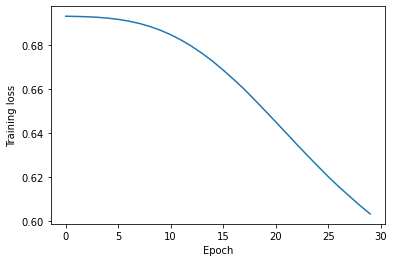

In [20]:
plt.plot([x[0] for x in all_train_losses], [x[1] for x in all_train_losses])
plt.xlabel("Epoch")
plt.ylabel("Training loss")

plt.show()

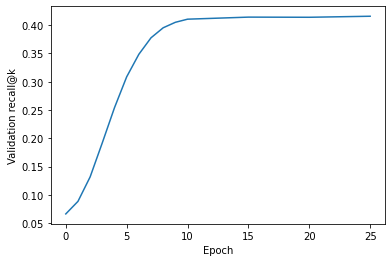

In [21]:
plt.plot([x[0] for x in all_val_recalls], [x[1] for x in all_val_recalls])
plt.xlabel("Epoch")
plt.ylabel("Validation recall@k")
plt.show()

Let's say, we want to visualise the embeddings of the country songs in our dataset. Since the number of dimensions in our embeddings is 64, we need to apply PCA, so it could be visualised in 2D space.

In [22]:
pca_embs = []
for i in range(11): # just visualizing epochs 0-10
    embs = torch.load(os.path.join('embeddings/embeddings_epoch_' + str(i) + '.pt'), map_location=torch.device('cpu'))
    pca = PCA(n_components=2).fit_transform(embs)
    pca_embs.append(pca)
    
# Load playlist/song details
with open('playlist_info.json', 'r') as f:
  playlists = json.load(f)
  playlists = {int(k): v for k, v in playlists.items()}

with open('song_info.json', 'r') as f:
  songs = json.load(f)
  songs = {int(k): v for k, v in songs.items()}

Finally, we can plot our embeddings at different epochs.

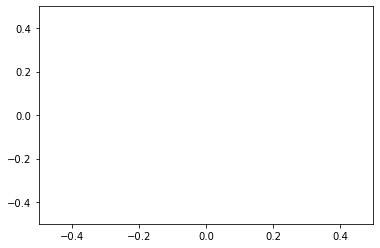

In [24]:
# Find all playlists with "country" in the title
country = []
country_colors = [] # colors for plotting
for id in playlists:
    name = playlists[id]['name'].lower()
    if 'country' in name:
        country.append(country)
        country_colors.append(0)
    else:
        country_colors.append(1)
        
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.5, 0.5))
ax.set_ylim((-0.5, 0.5))

colors = ['red', 'skyblue']
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)


scat = ax.scatter([], [], c=[], s=3, alpha=0.3, cmap=cmap)

In [76]:
#Example demo for 4th epoch
embs = pca_embs[4]
x, y = embs[:num_playlists, 0], embs[:num_playlists, 1]

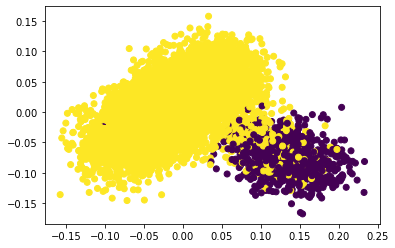

In [77]:
plt.scatter(x, y, c = country_colors)

We see how embeddings get more and more distinct with every epoch which compares to the ground truth (we coloured country songs using node information from the dataset).